# Case 1-5: 日銀のREIT, ETF買い入れとREIT, 株価指数の関係を見てみる
Correlation between ETF/J-REIT purchases and stock prices

In [1]:
%matplotlib inline
import seaborn as sns
import requests
import zipfile
import pandas as pd
from io import BytesIO
import pandas as pd

## 日本銀行のサイトからETF、REITの買入結果を取得する
download ETF/J-REIT purchases data from BOJ site

> 日本銀行  
> 指数連動型上場投資信託受益権（ETF）および不動産投資法人投資口（J-REIT）の買入結果  
> http://www3.boj.or.jp/market/jp/menu_etf.htm

元のファイルはzipファイルなので、展開する関数を用意  
make function for unzip

In [2]:
def extract_zip(input_zip):
    input_zip=zipfile.ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

pandasからExcelファイルを読み込む場合はpandas.read_excel()を使う  
リンク先のzipファイルをメモリ上で処理する場合にはBytesIOを使う  
use pandas.read_excel() for reading Excel file in pandas  
use BytesIO for opening zip file on memory

In [3]:
def load_excet2df(url, filename):
    zipdata = BytesIO()
    res = requests.get(url, stream=True)
    zipdata.write(res.content)
    return pd.read_excel(BytesIO(extract_zip(zipdata)[filename]))

## ExcelファイルからETFとREITの買い入れ額を取得
get ETF/J-REIT purchases data from Excel files

In [4]:
try:
    etfreit_df = load_excet2df('http://www3.boj.or.jp/market/jp/etfreit.zip', '2016.xls')
except Exception:
    etfreit_df = pd.read_excel('data/2016.xls')

In [5]:
etfreit_df.head(10)

,Unnamed: 0,指数連動型上場投資信託受益権（ETF）および不動産投資法人投資口（J-REIT）の買入結果,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Purchases of ETFs and J-REITs,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,（億円)
3,NaN,NaN,NaN,NaN,（100 million yen)
4,NaN,約定日\nTrade Date,指数連動型上場投資信託受益権,NaN,不動産投資法人投資口\nJ-REIT
5,NaN,NaN,ETF,NaN,NaN
6,NaN,NaN,(1) 右記以外,(2) 設備投資および人材投資に積極的に取り組んでいる企業を支援するためのETF,NaN
7,NaN,NaN,Purchases of ETFs other than those mentioned i...,Purchases of ETFs to support investment in phy...,NaN
8,NaN,2016-04-01 00:00:00,336,NaN,12
9,NaN,2016-04-02 00:00:00,NaN,NaN,NaN


データを整形(クレンジング)  
cleansing data

In [6]:
etfreit_df = etfreit_df.iloc[8:, 1:].copy()
etfreit_df.columns = ['Date', 'ETF', 'Ohter ETF', 'REIT']
etfreit_df.set_index('Date', inplace=True)
etfreit_df = etfreit_df.astype(float)

In [7]:
etfreit_df.head(10)

,ETF,Ohter ETF,REIT
Date,,,
2016-04-01,336.0,NaN,12.0
2016-04-02,NaN,NaN,NaN
2016-04-03,NaN,NaN,NaN
2016-04-04,NaN,12.0,NaN
2016-04-05,333.0,12.0,NaN
2016-04-06,NaN,12.0,12.0
2016-04-07,333.0,12.0,NaN
2016-04-08,NaN,12.0,12.0
2016-04-09,NaN,NaN,NaN


## ExcelファイルからREITと平均株価を取得
get TSE REIT index and stock indices data from Excel

データが複数あるので整形用の関数を用意  
make funcation for shaping multiple data

In [8]:
def cleansing_df(input_df):
    df = input_df.copy()
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close']
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.astype(float)
    return df

In [9]:
def load_df(key):
    data_dict = ohlc_data_dict[key]
    try:
        df = cleansing_df(pd.read_csv(data_dict['link']))
    except Exception:
        df = cleansing_df(pd.read_csv(data_dict['data'], encoding='sjis'))
    return df

当日(終値 - 始値)の騰落率を算出  
get daily return (close price - open price)

In [10]:
def pct_change(data):
    return ((data['Close'] - data['Open']) / data['Close']) * 100

In [11]:
ohlc_data_dict = {'tse_reit_index': {'link': 'http://k-db.com/indices/I133/1d/2016?download=csv',
                                'data': 'data/indices_I133_1d_2016.csv'},
             'topix': {'link': 'http://k-db.com/indices/I102/1d/2016',
                      'data': 'data/indices_I102_1d_2016.csv'},
             'jpx400': {'link': 'http://k-db.com/indices/I103/1d/2016?download=csv',
                       'data': 'data/indices_I103_1d_2016.csv'},
             'nikkei225': {'link': 'http://k-db.com/indices/I101/1d/2016?download=csv',
                          'data': 'data/indices_I101_1d_2016.csv'}
             }

In [12]:
df = dict(zip(ohlc_data_dict.keys(), map(load_df, ohlc_data_dict.keys())))

In [13]:
reit_df = pd.concat([etfreit_df['REIT'],
                     df['tse_reit_index'].apply(pct_change, axis=1)], axis=1).dropna()
reit_df.columns = ['BOJ', 'TSE REIT INDEX']

## 日銀のREITの買い入れ額と東証REIT指数  
Purchases of ETFs and J-REITs and TSE REIT index

In [14]:
reit_df.head()

,BOJ,TSE REIT INDEX
Date,,
2016-04-01,12.0,-1.533002
2016-04-06,12.0,-0.399714
2016-04-08,12.0,0.784616
2016-04-11,12.0,0.003160
2016-04-15,12.0,-0.330606


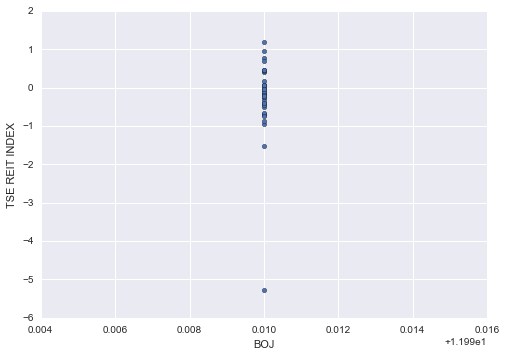

In [15]:
reit_df.plot(kind='scatter', x='BOJ', y='TSE REIT INDEX')

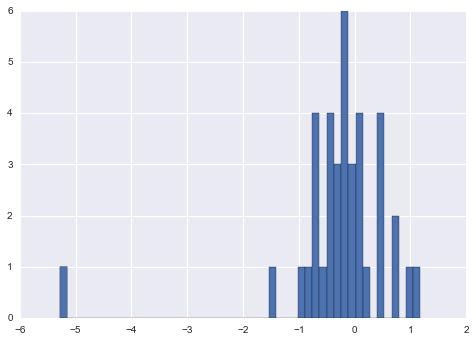

In [16]:
reit_df['TSE REIT INDEX'].hist(bins=50)

↑REITの買い入れがあった当日に必ずしも上昇しているわけではない  
TSE REIT index does not always rize when BOJ purchases amount of REIT.

## 日銀のETFの買い入れ額と平均株価  
Purchases of ETFs and stock average

In [17]:
stock_index_df = pd.concat([df['topix'].apply(pct_change, axis=1),
                            df['jpx400'].apply(pct_change, axis=1),
                            df['nikkei225'].apply(pct_change, axis=1)], axis=1)
stock_index_df = pd.concat([etfreit_df['ETF'], stock_index_df], axis=1).dropna()
stock_index_df.columns = ['BOJ', 'topix', 'jpx400', 'nikkei225']

In [18]:
stock_index_df.head()

,BOJ,topix,jpx400,nikkei225
Date,,,,
2016-04-01,336.0,-3.214999,-3.239965,-3.435997
2016-04-05,333.0,-2.116102,-2.086293,-1.979365
2016-04-07,333.0,0.417243,0.467328,0.067175
2016-04-11,333.0,-0.144555,-0.144684,-0.066281
2016-04-15,333.0,0.581754,0.610833,0.757596


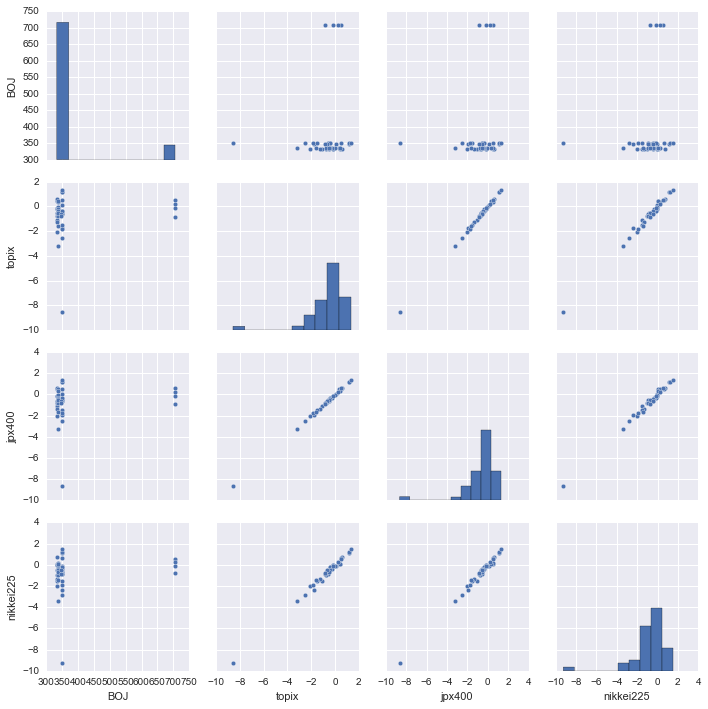

In [19]:
sns.pairplot(stock_index_df)

↑REITと同様にETFの買い入れがあった当日に必ずしも上昇しているわけではない  
stock average does not always rize when BOJ purchases amount of ETF.